In [1]:
import numpy as np
import os #ignore - used for debugging
import sys #ignore - used for debugging
import math
import time
import matplotlib.pyplot as plt
from matplotlib import colors
import random
import tracemalloc


In [2]:
def set_seed(seed_value):
    '''
    set seed value to reproduce the results
    input: seed_value
    '''
    np.random.seed(seed_value)

In [3]:
def create_board_randomly(n):
    '''
    creating a board randomnly of dimensions nxn
    placing each queen in a column
    input: n - dimensions (for our assignment - we can set it as 8)
    '''
    return(np.random.randint(0,n,n))

In [4]:
def combination(n):
    return math.comb(n,2)

In [5]:
def attacks(board):
    '''
    calculating the attacks on the queen
    actually there is no need to explicitly track conflicts in the columns - it would be redundant
    this is because we ensure that only one queen occupies every column
    input: we give the board configuration here
    '''
    n = len(board)
    '''
    keeps track of the queens along rows and 2 diagonals (main and secondary)
    '''
    row_count, diagmain_count, diagsecond_count = [0] * n , [0] * 2 * n, [0] * 2 * n
    for i in range(n): #i is every column on the board
        row_count[board[i]] += 1 #board[i] - gives you the row at which the queen is placed at column i
        diagmain_count[i + board[i]] += 1 # sets bound for the diagonal count
        diagsecond_count[i - board[i] + n] += 1 # same as above
    attacks = row_count + diagmain_count + diagsecond_count
    return sum(map(combination, attacks))

In [6]:
def print_board(board):
    '''
    print the board (might be helpful for debugging or for the report)
    '''
    n = len(board)
    display = np.zeros([n,n])
    #making alternate white and black rows and columns -  (odd row, even col and even row, odd col)
    display[1::2, ::2] = 1
    display[::2, 1::2] = 1
    fig, ax = plt.subplots()
    cols = ['white', 'gray']
    cmap = colors.ListedColormap(cols)
    ax.imshow(display, cmap = cmap, norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(n):
        plt.text(i, board[i], u"\u265B", fontsize = 48, horizontalalignment = 'center',verticalalignment = 'center')
    plt.show()
    print(f'queens [L-r] at rows: {board}')
    print(f'attacks: {attacks(board)}')


In [7]:
def simulated_annealing(initial_state, temperature, cooling_rate):
    '''
    Simulated Annealing for the 8-queens problem (or n)
    This function represents the problem space as a solution space with an initial state (starting solution, current state) and an energy function(Number of attacks)
    that quantifies the “goodness” of a solution.
    The algorithm begins with a given temperature and a random solution.
    Iteratively, it calculates a new random solution and selects it based on a probability function.
    This function considers whether the new solution is better or worse than the current accepted solution and takes into account the temperature.
    As the temperature decreases, the probability of accepting worse solutions diminishes.
    '''
    tracemalloc.start()
    snapshot1 = tracemalloc.take_snapshot()#Taking a snapshot before solving
    def get_neighbors(state):
        """Generate states in the neighborhood of the current state by moving one queen."""
        neighbors = []
        for i in range(len(state)):
            for j in range(len(state)):
                if state[i] != j:
                    neighbor = state.copy()
                    neighbor[i] = j
                    neighbors.append(neighbor)
        return neighbors
    current_state = initial_state #Getting the current state of the board
    current_energy = attacks(current_state) #Calculating the current energy (Number of attacks)
    print_board(current_state)
    best_state = current_state #Setting an initial value to the best state (will change later in the loop)
    best_energy = current_energy #Setting an initial value to the best energy(will change later in the loop)
    iteration = 0
    #This threshold is chosen to ensure that it does not run forever and run long enough to explore the solution space
    while temperature > 0.1:
        neighbor = random.choice(get_neighbors(current_state))
        neighbor_energy = attacks(neighbor)
        # Deciding whether to move the neighbor
        #If the new point improves the result of the objective function, we will move to the new point with probability 1.
        #The random.uniform(0,1) generates a random floating-point number between 0 and 1. It introduces randomness into the decision of whether to accept
        #a worse solution than the current one, enabling the algorithm to potentially escape local optima.
        if neighbor_energy < current_energy or random.uniform(0, 1) < math.exp((current_energy - neighbor_energy) / temperature):
            current_state = neighbor
            current_energy = neighbor_energy
            # Updating best solution found so far
            if current_energy < best_energy:
              best_state = current_state
              best_energy = current_energy
        # Cool down the temperature
        temperature *= (1 - cooling_rate)
        iteration += 1
        if best_energy == 0:  # Found a solution with zero attacks
          break
    snapshot2 = tracemalloc.take_snapshot()#Taking the final snapshot
    tracemalloc.stop()
    top_stats = snapshot2.compare_to(snapshot1,'lineno')#Calculating the memmory usage
    return best_state, best_energy, iteration, temperature,(top_stats[0].size_diff / 1024)


In [21]:
def run_experiment(vanilla_or_meta, board_size, name_function, num_runs=10):
    '''
    increase runs but comment print boards (you don't want overflowing output)
    input: function - can be steepest_ascent_hill_climbing (vanilla) or random_restart_hill_climbing (meta)
    '''
    #store values for all runs
    total_runtime, total_attacks, optimal_solutions = 0,0,0
    append_runtime, append_attacks, append_optimal_Solutions, which_iterations  = [],[],[], []
    i = 0
    average_memory =0;
    while i < num_runs:
        set_seed(i)
        board = create_board_randomly(board_size)
        print('#######################################################################################')
        print(f'Starting run {i+1} for {name_function}')
        # print_board(board) #comment if you find it annoying
        start_time = time.time() #record the start time
        # initial_state = [random.randint(0, 7) for _ in range(8)]  # Random initial state
        temperature = 5000  # Initial temperature
        cooling_rate = 0.0001  # Cooling rate
        best_board, result_attack, result_iteration, result_temperature ,memory = vanilla_or_meta(board,temperature,cooling_rate) #run the function
        print_board(best_board)#comment if you find it annoying
        end_time = time.time() # end the time
        run_time = end_time - start_time #calculate the difference
        total_runtime += run_time
        total_attacks += result_attack
        average_memory += memory
        append_runtime.append(run_time)
        append_attacks.append(result_attack)
        which_iterations.append(result_iteration)
        if result_attack == 0:
            optimal_solutions += 1
            append_optimal_Solutions.append(1)
        else:
            append_optimal_Solutions.append(0)
        print(f'\nEnding {i} run')
        print('Temperature:',result_temperature)
        print('Time:', run_time)
        print('Memory Usage:', memory)
        print('#######################################################################################\n')
        i += 1
    avg_runtime = total_runtime / num_runs
    avg_memory = average_memory/num_runs
    percent_attacks = (total_attacks / num_runs) * 100
    percent_optimal_solutions = (optimal_solutions / num_runs) * 100
    print('#######################################################################################\n\n')
    return avg_runtime, percent_attacks, percent_optimal_solutions, append_runtime, append_attacks, append_optimal_Solutions, which_iterations,avg_memory

In [22]:
def plot_results(steepest_ascent_results):
    metric = ['_','_','_','run_Times', 'attacks', 'optimal solutions']
    for i in {3,4,5}:
        plt.plot(list(range(1, 11)), steepest_ascent_results[i], label='Simulated Annealing')
        plt.xlabel('runs')
        plt.ylabel(metric[i].capitalize())
        plt.title(f'{metric[i].capitalize()} vs runs')
        plt.legend()
        plt.show()

#######################################################################################
Starting run 1 for simulated annealing


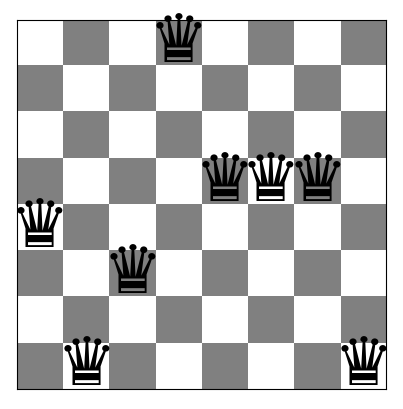

queens [L-r] at rows: [4 7 5 0 3 3 3 7]
attacks: 7


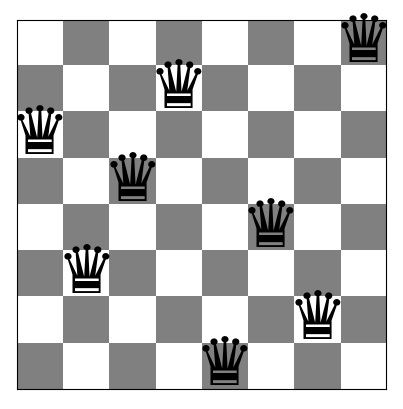

queens [L-r] at rows: [2 5 3 1 7 4 6 0]
attacks: 0

Ending 0 run
Temperature: 1.3418939733813877
Time: 20.65376091003418
Memory Usage: 58.21875
#######################################################################################

#######################################################################################
Starting run 2 for simulated annealing


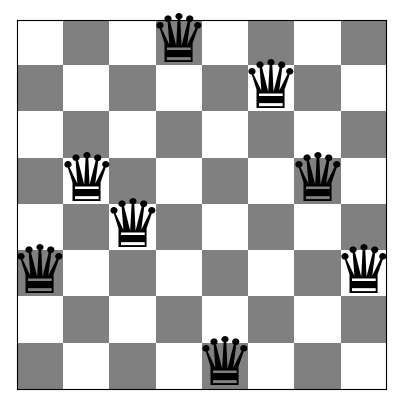

queens [L-r] at rows: [5 3 4 0 7 1 3 5]
attacks: 5


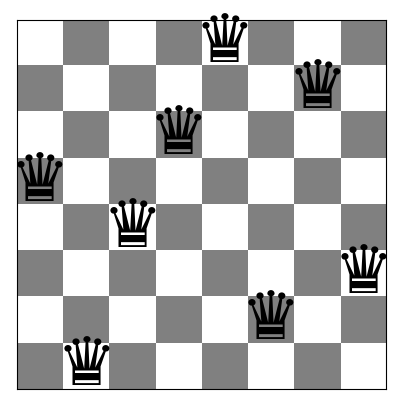

queens [L-r] at rows: [3 7 4 2 0 6 1 5]
attacks: 0

Ending 1 run
Temperature: 1.3525374543461481
Time: 20.27904963493347
Memory Usage: 58.21875
#######################################################################################

#######################################################################################
Starting run 3 for simulated annealing


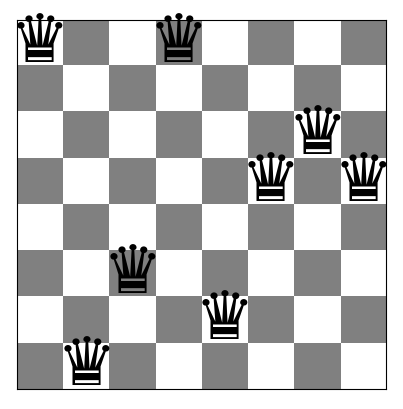

queens [L-r] at rows: [0 7 5 0 6 3 2 3]
attacks: 7


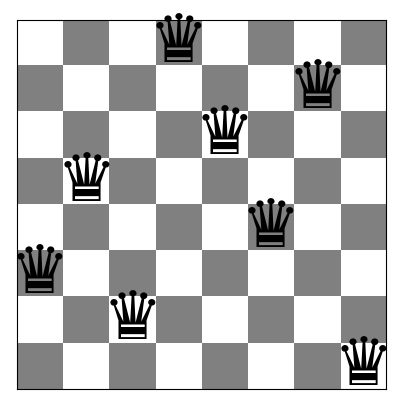

queens [L-r] at rows: [5 3 6 0 2 4 1 7]
attacks: 0

Ending 2 run
Temperature: 0.8491318091193923
Time: 20.508897066116333
Memory Usage: 58.21875
#######################################################################################

#######################################################################################
Starting run 4 for simulated annealing


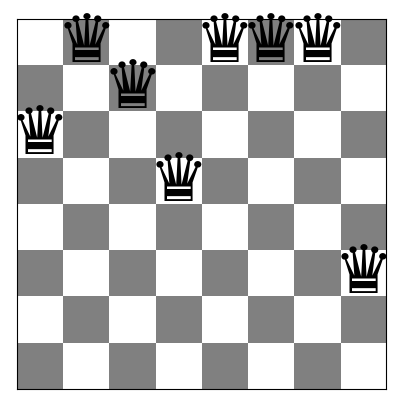

queens [L-r] at rows: [2 0 1 3 0 0 0 5]
attacks: 8


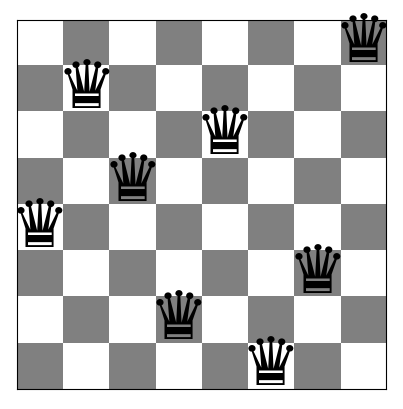

queens [L-r] at rows: [4 1 3 6 2 7 5 0]
attacks: 0

Ending 3 run
Temperature: 1773.20045232539
Time: 3.207386016845703
Memory Usage: 58.21875
#######################################################################################

#######################################################################################
Starting run 5 for simulated annealing


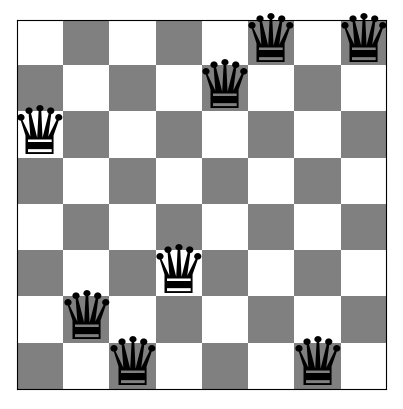

queens [L-r] at rows: [2 6 7 5 1 0 7 0]
attacks: 6


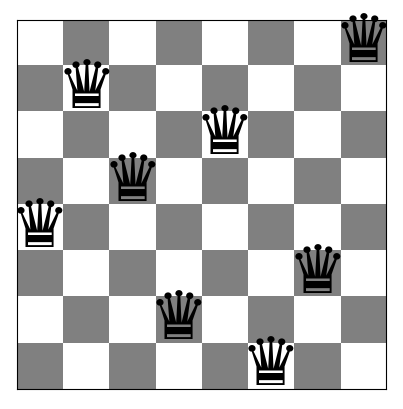

queens [L-r] at rows: [4 1 3 6 2 7 5 0]
attacks: 0

Ending 4 run
Temperature: 1.1139059566144511
Time: 19.981820106506348
Memory Usage: 58.21875
#######################################################################################

#######################################################################################
Starting run 6 for simulated annealing


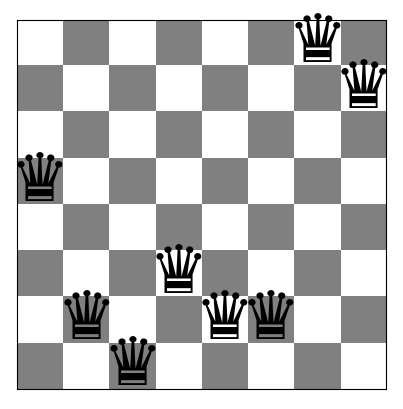

queens [L-r] at rows: [3 6 7 5 6 6 0 1]
attacks: 7


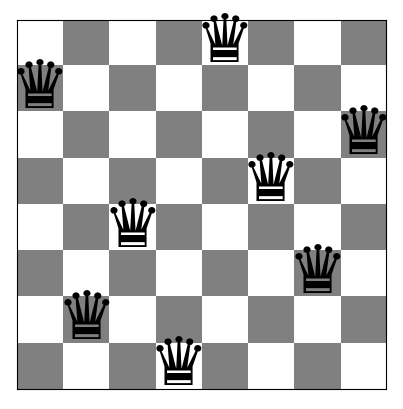

queens [L-r] at rows: [1 6 4 7 0 3 5 2]
attacks: 0

Ending 5 run
Temperature: 1.466804872846401
Time: 20.1690514087677
Memory Usage: 58.21875
#######################################################################################

#######################################################################################
Starting run 7 for simulated annealing


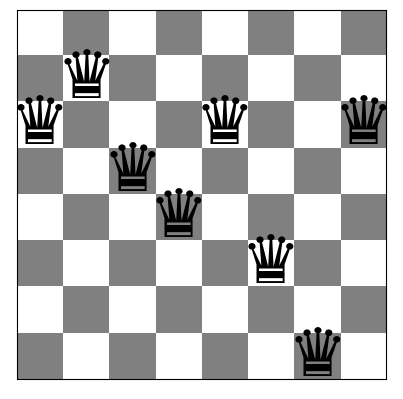

queens [L-r] at rows: [2 1 3 4 2 5 7 2]
attacks: 8


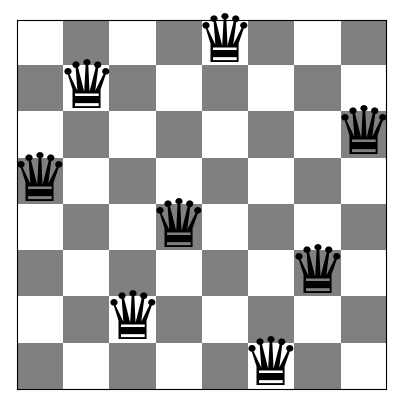

queens [L-r] at rows: [3 1 6 4 0 7 5 2]
attacks: 0

Ending 6 run
Temperature: 1654.969581246456
Time: 2.7798800468444824
Memory Usage: 58.21875
#######################################################################################

#######################################################################################
Starting run 8 for simulated annealing


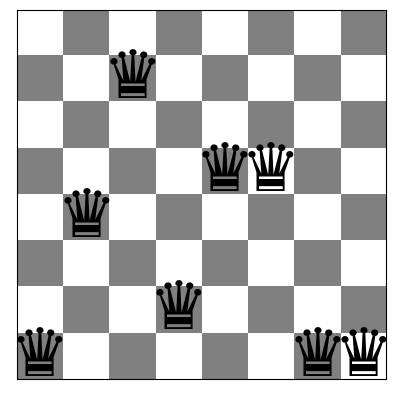

queens [L-r] at rows: [7 4 1 6 3 3 7 7]
attacks: 7


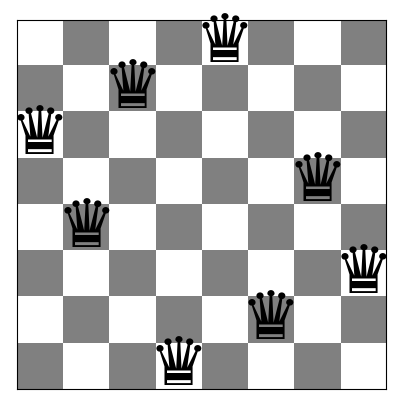

queens [L-r] at rows: [2 4 1 7 0 6 3 5]
attacks: 0

Ending 7 run
Temperature: 4.8304811190624495
Time: 16.655699014663696
Memory Usage: 59.46875
#######################################################################################

#######################################################################################
Starting run 9 for simulated annealing


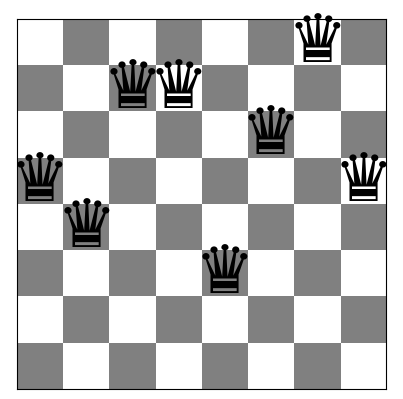

queens [L-r] at rows: [3 4 1 1 5 2 0 3]
attacks: 4


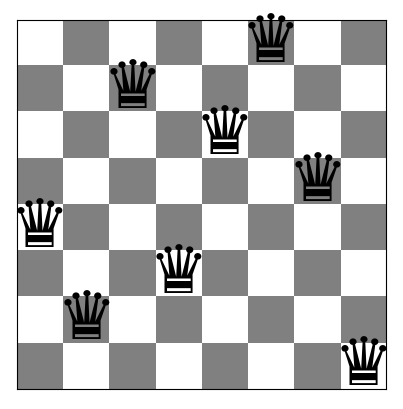

queens [L-r] at rows: [4 6 1 5 2 0 3 7]
attacks: 0

Ending 8 run
Temperature: 0.5896895401362892
Time: 22.36642622947693
Memory Usage: 58.21875
#######################################################################################

#######################################################################################
Starting run 10 for simulated annealing


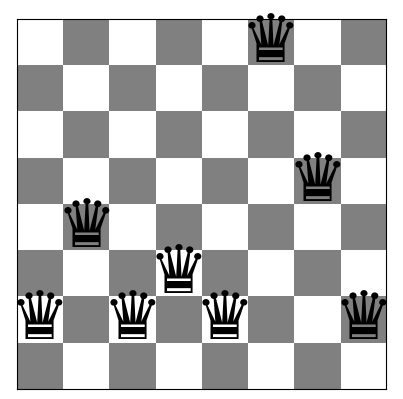

queens [L-r] at rows: [6 4 6 5 6 0 3 6]
attacks: 9


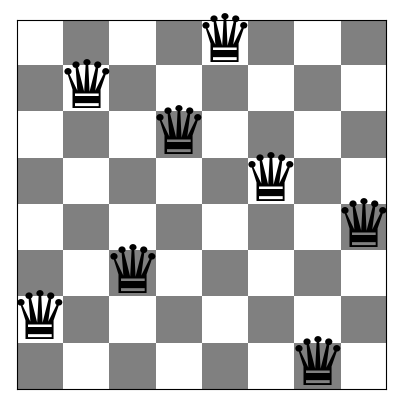

queens [L-r] at rows: [6 1 5 2 0 3 7 4]
attacks: 0

Ending 9 run
Temperature: 54.98539922662472
Time: 11.168899297714233
Memory Usage: 58.21875
#######################################################################################

#######################################################################################




In [23]:
board_size = 8
simulated_annealing_results = run_experiment(simulated_annealing, board_size, 'simulated annealing')

In [25]:
print('HC version\t\tboard size\tavg run time\t\tattacks% \toptimal solutions% \taverage memory')
print(f'Simulated Annealing\t{board_size}\t\t{simulated_annealing_results[0]:.5f}\t\t{simulated_annealing_results[1]:.2f}\t\t{simulated_annealing_results[2]:.2f} \t\t\t {simulated_annealing_results[7]: .2f}KB')


HC version		board size	avg run time		attacks% 	optimal solutions% 	average memory
Simulated Annealing	8		15.77709		0.00		100.00 			  58.34KB


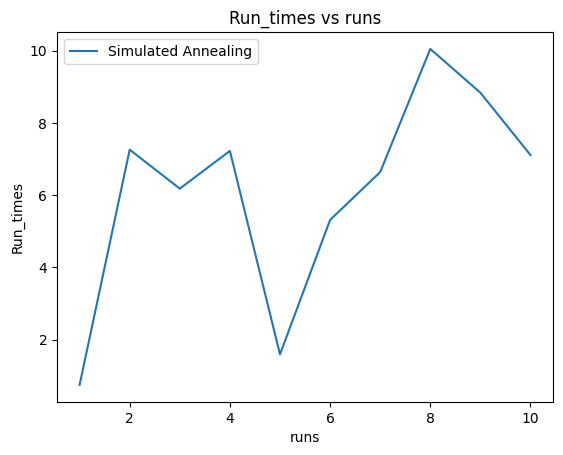

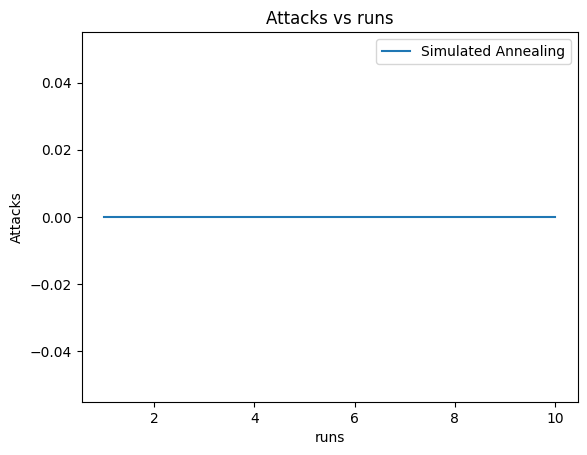

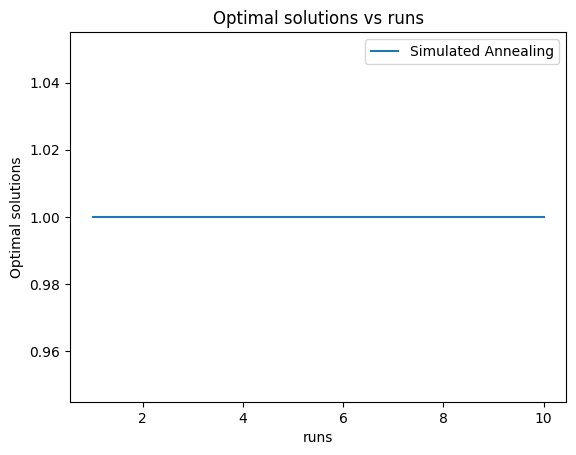

In [ ]:
plot_results(simulated_annealing_results)